 Xây dựng mô hình dựa vào lexicon (từ điển cảm xúc) để dự đoán sentiment của review (Positive, Negative, Neutral).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('/content/data_file.csv')
df.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment,polarity,length,word_counts
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sou...,Positive,0.3500,154,25
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized ...,Positive,0.0000,337,54
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwis...,Positive,0.1675,296,45
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop ...,Positive,0.4250,169,23
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio fil...,Positive,0.8000,114,18


In [ ]:
df.describe()

,overall,unixReviewTime,polarity,length,word_counts
count,10261.000000,1.026100e+04,10261.000000,10261.000000,10261.000000
mean,4.488744,1.360606e+09,0.283765,308.750901,48.229412
std,0.894642,3.779735e+07,0.198325,376.318391,57.312309
min,1.000000,1.095466e+09,-0.800000,12.000000,2.000000
25%,4.000000,1.343434e+09,0.156845,114.000000,18.000000
50%,5.000000,1.368490e+09,0.267949,187.000000,30.000000
75%,5.000000,1.388966e+09,0.400000,345.000000,54.000000
max,5.000000,1.405987e+09,1.000000,7233.000000,1112.000000


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()

# Tính điểm sentiment
df['vader_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(str(x))['compound'])

# Gán nhãn dự đoán từ mô hình
def get_vader_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment'] = df['vader_score'].apply(get_vader_sentiment)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


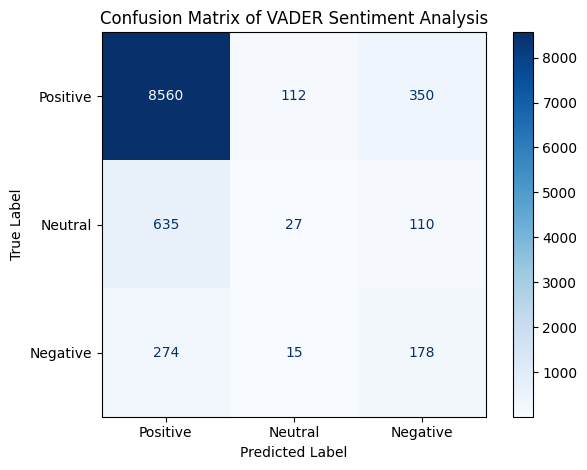

Confusion Matrix:
[[ 178   15  274]
 [ 110   27  635]
 [ 350  112 8560]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.28      0.38      0.32       467
     Neutral       0.18      0.03      0.06       772
    Positive       0.90      0.95      0.93      9022

    accuracy                           0.85     10261
   macro avg       0.45      0.45      0.44     10261
weighted avg       0.82      0.85      0.83     10261



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Tính confusion matrix
cm = confusion_matrix(df['sentiment'], df['vader_sentiment'], labels=["Positive", "Neutral", "Negative"])

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Neutral", "Negative"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of VADER Sentiment Analysis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(confusion_matrix(df['sentiment'], df['vader_sentiment']))



print("\nClassification Report:")
print(classification_report(df['sentiment'], df['vader_sentiment']))


Markov Chain

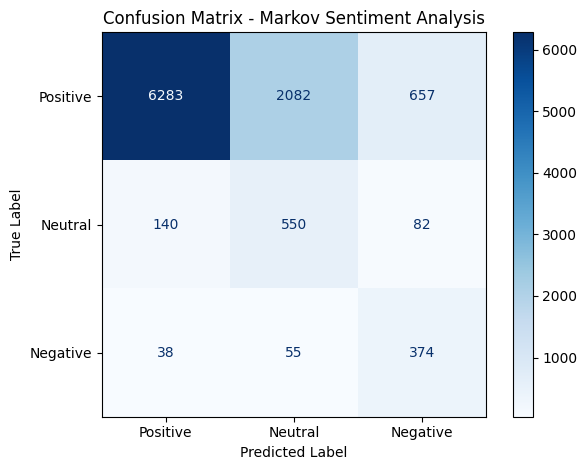

Confusion Matrix:
[[6283 2082  657]
 [ 140  550   82]
 [  38   55  374]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.34      0.80      0.47       467
     Neutral       0.20      0.71      0.32       772
    Positive       0.97      0.70      0.81      9022

    accuracy                           0.70     10261
   macro avg       0.50      0.74      0.53     10261
weighted avg       0.89      0.70      0.76     10261



In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Giả sử df là DataFrame đã có sẵn với các cột: 'reviews' và 'sentiment'
# Tiền xử lý văn bản đơn giản
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.split()

# Cân bằng dữ liệu theo từng lớp (500 mẫu mỗi lớp)
def balance_data(df):
    df_pos = resample(df[df.sentiment == 'Positive'], replace=False, n_samples=500, random_state=42)
    df_neu = resample(df[df.sentiment == 'Neutral'], replace=True, n_samples=500, random_state=42)
    df_neg = resample(df[df.sentiment == 'Negative'], replace=True, n_samples=500, random_state=42)
    return pd.concat([df_pos, df_neu, df_neg])

# Xây mô hình Markov (bigram)
def build_markov_model(reviews):
    model = {}
    unigram_counts = {}
    for review in reviews:
        tokens = preprocess(review)
        for i in range(len(tokens)):
            unigram_counts[tokens[i]] = unigram_counts.get(tokens[i], 0) + 1
            if i < len(tokens) - 1:
                curr, next_ = tokens[i], tokens[i+1]
                if curr not in model:
                    model[curr] = {}
                model[curr][next_] = model[curr].get(next_, 0) + 1
    total_unigrams = sum(unigram_counts.values())
    unigram_probs = {k: v / total_unigrams for k, v in unigram_counts.items()}
    return model, unigram_probs

# Tính log-probability có Laplace smoothing
def markov_log_probability(tokens, model, vocab_size=10000):
    log_prob = 0
    for i in range(len(tokens) - 1):
        curr, next_ = tokens[i], tokens[i+1]
        transitions = model.get(curr, {})
        total = sum(transitions.values()) + vocab_size
        count = transitions.get(next_, 0) + 1
        log_prob += np.log(count / total)
    return log_prob

# Kết hợp bigram và unigram
def combined_log_probability(tokens, bigram_model, unigram_model, alpha=0.7):
    bigram_log = markov_log_probability(tokens, bigram_model)
    unigram_log = sum(np.log(unigram_model.get(word, 1e-6)) for word in tokens)
    return alpha * bigram_log + (1 - alpha) * unigram_log

# Dự đoán sentiment
def predict_sentiment(text, models):
    tokens = preprocess(text)
    scores = {}
    for label, (bigram_model, unigram_model) in models.items():
        scores[label] = combined_log_probability(tokens, bigram_model, unigram_model)
    return max(scores, key=scores.get)

# === Bắt đầu huấn luyện và đánh giá ===

# Cân bằng dữ liệu
df_balanced = balance_data(df)

# Huấn luyện mô hình Markov cho từng sentiment
models = {}
for label in ['Positive', 'Neutral', 'Negative']:
    sub_reviews = df_balanced[df_balanced.sentiment == label]['reviews']
    models[label] = build_markov_model(sub_reviews)

# Dự đoán trên toàn bộ tập gốc (hoặc có thể dùng tập test riêng)
df['markov_sentiment'] = df['reviews'].apply(lambda x: predict_sentiment(x, models))

# Đánh giá
cm = confusion_matrix(df['sentiment'], df['markov_sentiment'], labels=["Positive", "Neutral", "Negative"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Neutral", "Negative"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Markov Sentiment Analysis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(df['sentiment'], df['markov_sentiment'], zero_division=0))
